# Fasttext tweet classification

## Data file creation

In [4]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import random
import re
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [5]:
DATADIR = "../data/"
TOPIC = "distance"
FILETWEETS = TOPIC+"-tweets.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
ANNOTATOR = "erikt@xs4all.nl"

In [6]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")

In [7]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

In [5]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if annotator == ANNOTATOR and tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:" ".join(TweetTokenizer().tokenize(cleanup(tweets.loc[tweetId][TEXT])))}

In [8]:
len(fasttextData)

5977

In [ ]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    text = cleanup(fasttextData[tweetId][TEXT])
    if not text in seenTexts:
        print(fasttextData[tweetId][LABEL],text,file=outFile)
        seenTexts[text] = True
outFile.close()

In [6]:
annotations1 = annotations[annotations[0]==ANNOTATOR]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations1[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations1[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 5.3 ; 1000 tweets take: 189 minutes


In [7]:
annotations2 = annotations[annotations[0]!=ANNOTATOR]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations2[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations2[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

tweets annotated per minute: 3.0 ; 1000 tweets take: 329 minutes


## Fasttext run and evaluation

In [8]:
import fasttext
import random
from IPython.display import clear_output

In [9]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [10]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [11]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

5732

In [12]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

In [13]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [14]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None):
    predictionCounts = []
    predictionLabels = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart = round(fold*len(fasttextData)/n)
        testEnd = round((fold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        trainData = []
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i < testStart or i >= testEnd: 
                print(data,file=trainFile)
                trainData.append(data)
            else: 
                print(data,file=testFile)
                testData.append(data)
        testFile.close()
        trainFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCounts.append([*model.test(TEST)])
        predictionLabels.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCounts,predictionLabels)

In [15]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

In [16]:
def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    for label in ['__label__REJECTS','__label__REJECTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,3)]
    factor = sum(cf.loc['__label__SUPPORTS'])*sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])/\
             (sum(cf.loc['__label__REJECTS'])*sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))]))
    if printResults: print("cases: {0}; precision: {1}; recall: {2}; factor: {3:0.3f}".format(caseTotal,precision,recall,factor))
    return((precision,factor))

## Grid search

In [ ]:
scores = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200,300]:
        for lr in [0.05,0.1,0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = " ".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

In [ ]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][0],reverse=True)][0:10]

In [ ]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][1],reverse=True)][0:10]

In [ ]:
N = 5
scoresN = {} 
triplets = [(10,300,0.9),(10,300,1.0),(10,500,0.9),(10,300,0.5),(20,300,0.9),(10,300,0.2),(20,300,0.2),(200,300,0.2)]

for triplet in triplets:
    dim,epoch,lr = triplet
    key = " ".join([str(dim),str(epoch),str(lr)])
    scoresN[key] = []
    for i in range(0,N): 
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
        print(dim,epoch,lr,end=" ")
        scoresN[key].append(evaluate(predictionCounts,predictionLabels,fasttextData))

In [ ]:
scoresNaverage = {}
for key in scoresN: scoresNaverage[key] = round(np.average([x[1] for x in scoresN[key]]),3)
{key:scoresNaverage[key] for key in sorted(scoresNaverage.keys(),key=lambda k:scoresNaverage[k],reverse=True)}

## Run with best parameters

In [17]:
BESTDIM = 20
BESTEPOCH = 300
BESTLR = 0.9

predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [19]:
evaluate(predictionCounts,predictionLabels,fasttextData)

cases: 5732; precision: 0.638; recall: 0.638; factor: 0.840


(0.638, 0.8404354281558694)

In [20]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__REJECTS': 1138,
 '__label__SUPPORTS': 3222,
 '__label__IRRELEVANT': 1372}

In [21]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.562


In [22]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__IRRELEVANT': 1219,
 '__label__SUPPORTS': 3480,
 '__label__REJECTS': 1033}

In [23]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 516


In [24]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__REJECTS': 0.092, '__label__SUPPORTS': 0.08, '__label__IRRELEVANT': 0.112}


In [25]:
makeConfusionMatrix(fasttextData,predictionLabels)

col_0,__label__IRRELEVANT,__label__REJECTS,__label__SUPPORTS
row_0,,,
__label__IRRELEVANT,548,204,620
__label__REJECTS,217,586,335
__label__SUPPORTS,454,243,2525


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [26]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__REJECTS': 1.101645692158761,
 '__label__SUPPORTS': 0.9258620689655173,
 '__label__IRRELEVANT': 1.125512715340443}

For mondkapje tweets, the multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [27]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

5732.0 5732


## Relation data size - accuracy

In [28]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000,10000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False,maxTrain=trainingSize)
        expResultsTrainingSize.append(evaluate(predictionCounts,predictionLabels,fasttextData,printResults=False))
    average = (np.average([x[0] for x in expResultsTrainingSize]),np.average([x[1] for x in expResultsTrainingSize]))
    expResultsAll[len(selection)] = average
    print("{0:4} {1:0.3f} {2:0.3f}".format(len(selection),average[0],average[1]))
    if len(selection) >= len(fasttextData): break

 100 0.530 0.404
 200 0.545 0.583
 500 0.567 0.701
1000 0.590 0.746
2000 0.607 0.796
5000 0.631 0.856
5732 0.634 0.846


In [30]:
del(expResultsAll[5732])

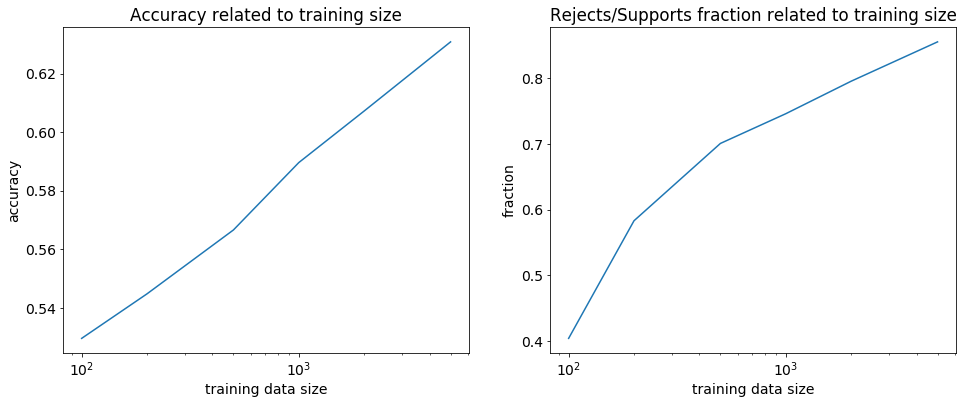

In [73]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
plt.plot(list(expResultsAll.keys()),[x[0] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("accuracy")
plt.xlabel("training data size")
plt.title("Accuracy related to training size")

ax1 = plt.subplot(122)
plt.plot(list(expResultsAll.keys()),[x[1] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("fraction")
plt.xlabel("training data size")
plt.title("Rejects/Supports fraction related to training size")

plt.show()

## Classifying unlabeled tweets

In [18]:
import fasttext
import matplotlib
import os
import pandas as pd
import re

In [54]:
DATADIRECTORY = "/home/erikt/projects/puregome/data/text/"
DATADIRECTORY = "/home/erikt/projects/puregome/data/nunl/"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
SUPPORT = ""
TEXT = "text"
USER = "user"
TOTAL = "total"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [69]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query):
    fileList = sorted(os.listdir(DATADIRECTORY))
    tmpFileName = "classify."+str(int(random.random()*LARGEINT))+".txt"
    grepCommand = makeGrepCommandFromQuery(query)
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName):
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| head -1 >"+tmpFileName)
            os.system("gunzip -c "+DATADIRECTORY+inFileName+" 2>/dev/null| "+grepCommand+" >> "+tmpFileName)
            try: 
                df = pd.read_csv(tmpFileName).drop_duplicates()
                testData.extend(list(df[TEXT]))
            except: 
                pass
            os.unlink(tmpFileName)
    return(testData)
    
def classify(datePattern,query,model):
    testData = readData(datePattern,query)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    labelPercentages[TOTAL] = nbrOfLabels
    return(labelPercentages)

In [56]:
QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
MAXDAYSPERMONTH = 31

results = {}
print("building model...")
model = fasttext.train_supervised(FILEFASTTEXT,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)
print("classifying...")
for month in "202002 202003 202004 202005 202006 202007".split():
    for day in range(1,MAXDAYSPERMONTH+1):
        date = month+str(day).zfill(2)
        try:
            labels = classify(date,QUERY,model)
            if not REJECTS in labels: labels[REJECTS] = 0
            if not SUPPORTS in labels: labels[SUPPORTS] = 0
            if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
            if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                results[date] = labels
                print(date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT],labels[TOTAL])
        except:
            print(date,"error")

building model...
classifying...
20200201 error
20200202 error
20200203 error
20200204 error
20200205 error
20200206 error
20200207 error
20200208 error
20200209 error
20200210 error
20200211 error
20200212 error
20200213 error
20200214 error
20200215 error
20200216 error
20200217 error
20200218 error
20200219 error
20200220 error
20200221 error
20200222 error
20200223 error
20200224 error
20200225 error
20200226 error
20200227 error
20200228 error
20200229 error
20200230 error
20200231 error
20200301 error
20200302 error
20200303 error
20200304 error
20200305 error
20200306 error
20200307 error
20200308 error
20200309 error
20200310 error
20200311 error
20200312 error
20200313 error
20200314 error
20200315 error
20200316 error
20200317 error
20200318 error
20200319 error
20200320 error
20200321 error
20200322 error
20200323 error
20200324 error
20200325 error
20200326 error
20200327 error
20200328 error
20200329 error
20200330 error
20200331 error
20200401 error
20200402 error
2020040

## Visualization over time

In [57]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [58]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

In [60]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7

x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

keyDates = []
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        keyDates.append(list(results.keys())[i])
        print(keyDates[-1])

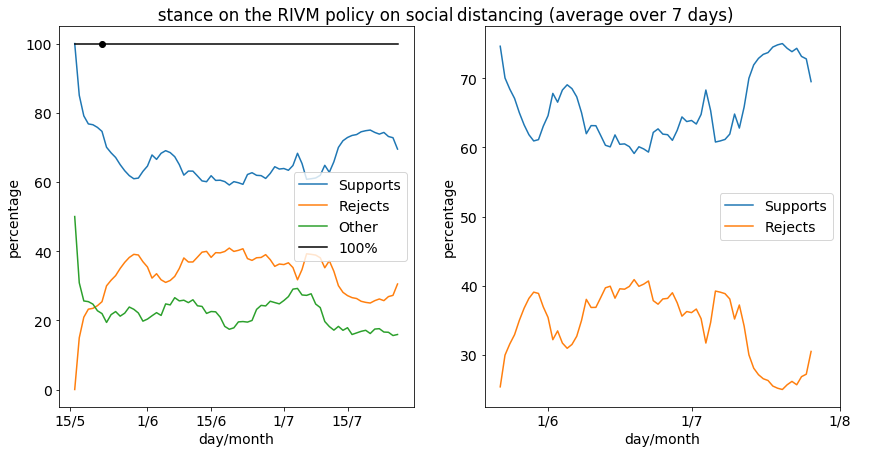

In [68]:
STARTDATE = "20200522" # keyDates[0]
ENDDATE = "20201231"
PLOTFILEOUT = "social-distancing.png"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(14,7))

ax1 = plt.subplot(121)
plt.plot_date(x,ySupports,fmt="-",label="Supports")
plt.plot_date(x,yRejects,fmt="-",label="Rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="Other")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("                          stance on the RIVM policy on "+"social")

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(122)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="Supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="Rejects")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("distancing (average over "+str(DAYSCOMBINED)+" days)                         ")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in " 20200601 20200701 20200801".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.savefig(PLOTFILEOUT)
plt.show()

In [56]:
counts = {}
for text in fasttextData:
    label = text.split()[0]
    if label in counts: counts[label] += 1
    else: counts[label] = 1
for label in counts: print(round(counts[label]/len(fasttextData),3),label)

0.199 __label__REJECTS
0.562 __label__SUPPORTS
0.239 __label__IRRELEVANT


## Annotator comparison

In [68]:
NBROFTESTDATA = 100

annotators = []
annotatorData = {}
kappaData = [{},{}]
blockedTweetIds = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if not annotator in annotatorData: 
        annotatorData[annotator] = {}
        annotators.append(annotator)
    annotatorData[annotator][tweetId] = tweetLabel
    if len(annotatorData[annotator]) <= NBROFTESTDATA: blockedTweetIds[tweetId] = True
    if len(annotators) >= 2 and not tweetId in blockedTweetIds and \
       tweetId in annotatorData[annotators[0]] and tweetId in annotatorData[annotators[1]]:
        kappaData[0][tweetId] = annotatorData[annotators[0]][tweetId]
        kappaData[1][tweetId] = annotatorData[annotators[1]][tweetId]

In [41]:
for annotator in annotatorData:
    labelCount = {}
    for tweetId in annotatorData[annotator]:
        label = annotatorData[annotator][tweetId]
        if not label in labelCount: labelCount[label] = 0
        labelCount[label] += 1
    print(len(annotatorData[annotator]))
    for label in labelCount: print(round(labelCount[label]/len(annotatorData[annotator]),3),label)

5977
0.2 ONEENS
0.562 EENS
0.238 ANDERS
501
0.214 ONEENS
0.421 ANDERS
0.361 EENS
0.004 NEUTRAL
100
0.6 EENS
0.21 ONEENS
0.19 ANDERS


In [72]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score([kappaData[0][tweetId] for tweetId in kappaData[0]],[kappaData[1][tweetId] for tweetId in kappaData[0]])

0.595249310275217

In [42]:
MAX = 100

total = 0
identical = 0
for tweetId in annotatorData[ANNOTATOR]:
    for annotator in annotators:
        if not annotator == ANNOTATOR and tweetId in annotatorData[annotator]:
            total += 1
            if total <= MAX:
                if annotatorData[annotator][tweetId] == annotatorData[ANNOTATOR][tweetId]: identical += 1
                else: 
                    print(tweetId,annotatorData[ANNOTATOR][tweetId],annotatorData[annotator][tweetId])
                    #print(tweets.loc[tweetId][TEXT])
print(total,identical)

1255811493528027142 ONEENS EENS
1268107342220005377 EENS ANDERS
1267584204696702980 EENS ANDERS
1275089022595956737 ONEENS EENS
1278679339618439168 ONEENS EENS
1262358344687329280 ONEENS EENS
1261162132286189568 ONEENS ANDERS
1269734750245306369 ANDERS EENS
1268291329366220800 ONEENS EENS
1264617033108467712 EENS ANDERS
1268229980351279117 EENS ANDERS
1271354707177623553 ONEENS EENS
1260396460736229380 ONEENS ANDERS
1239097671090143237 EENS ANDERS
1268553585492733953 ANDERS EENS
1242901282312126472 ANDERS EENS
1226455377698607104 ANDERS ONEENS
1242710941961256960 EENS ANDERS
1242710941961256960 EENS ONEENS
1265168472402771969 ONEENS ANDERS
1256556830374977537 EENS ANDERS
1263261354074480640 ANDERS EENS
1252311452981112838 ONEENS EENS
1267535134213001216 ANDERS ONEENS
1267535134213001216 ANDERS ONEENS
1266518198637256707 ONEENS ANDERS
1266518198637256707 ONEENS ANDERS
1246404764524523520 EENS ANDERS
1246404764524523520 EENS ANDERS
1262462245411459079 ANDERS ONEENS
1246210326942679041 EE